# 0. Preparation

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)
plt.rcParams['figure.figsize'] = [6, 3]

2023-04-02 22:39:10.931347: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-02 22:39:10.980476: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-02 22:39:10.981542: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 22:39:11.788003: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 42
Global seed set to 42


# Load data from Azure blob

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Download full data
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"
local_file = tmp_dir + os.sep + blob_name

data_df = get_raw_datasets(container, blob_name)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


## Model Params

In [5]:
# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*5 #  year
print(f"Training timestemp length = {SUBSET_LEN}.")

# create dataloaders for model
batch_size = 256  # set this between 32 to 128
cpu_count = os.cpu_count()

Training timestemp length = 43800.


In [6]:
def setup_tsdataset_nogpp_slim(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)


In [ ]:
## Model Results Directories:
model_dirs = [
    "tft_model_14_1_5YrTrain_3DEncode_SmallNetwork_TopFeatures_NoGPP_230402_2227",
    #"",
    #"",
    "tft_model_5YrTrain_30DEncode_SmallNetwork_Top7Features_NoGPP_230402_1700"
]

checkpts = []
for model_dir in model_dirs:
    checkpt_dir = f"/root/co2-flux-hourly-gpp-modeling/data/models/{model_dir}/lightning_logs/version_0/checkpoints/"
    checkpt = os.listdir(checkpt_dir)[-1]
    checkpts.append(f"{checkpt_dir}{checkpt}")
    
    
encoder_lens = [3,
                #7, 
                #14, 
                30]

for i in range(len(encoder_lens)):
    print(f"\n\nExp 14_{i+1}, Encoder Length = {encoder_lens[i]}D")
    # Set constants
    ENCODER_LEN = 24*encoder_lens[i]
    exp_model_dir = model_dirs[i]
    best_model_path = checkpts[i]
    
    # Load best model
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
    
    # Setup dataset
    train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
    train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
    train, validation, _ = setup_tsdataset_nogpp_slim(train_df, val_df, None, ENCODER_LEN)
    
    # Get raw preds
    raw_predictions = best_tft.predict(validation, mode="raw", return_x=False, show_progress_bar=False)
    
    # Get interpretation
    interpretation_sum = best_tft.interpret_output(raw_predictions, reduction="sum")
    best_tft.plot_interpretation(interpretation_sum)
    print("\n")
    



Exp 14_1, Encoder Length = 3D
Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752


Exp 14_2, Encoder Length = 30D
Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752


In [ ]:
## Model Results Directories:
model_dirs = [
    "",
    "",
    "",
    "tft_model_5YrTrain_30DEncode_SmallNetwork_Top7Features_NoGPP_230402_1700"
]

checkpts = []
for model_dir in model_dirs:
    checkpt_dir = f"/root/co2-flux-hourly-gpp-modeling/data/models/{model_dir}/lightning_logs/version_0/checkpoints/"
    checkpt = os.listdir(checkpt_dir)[-1]
    checkpts.append(f"{checkpt_dir}{checkpt}")
    
    
encoder_lens = [3, 7, 14, 30]

for i in range(len(encoder_lens)):
    print(f"\n\nExp 14_{i+1}, Encoder Length = {encoder_lens[i]}D")
    # Set constants
    ENCODER_LEN = 24*encoder_lens[i]
    exp_model_dir = model_dirs[i]
    best_model_path = checkpts[i]
    
    # Load best model
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
    
    # Setup dataset
    train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
    train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
    train, validation, _ = setup_tsdataset_nogpp_slim(train_df, val_df, None, ENCODER_LEN)
    
    # Get raw preds
    raw_predictions = best_tft.predict(validation, mode="raw", return_x=False, show_progress_bar=False)
    
    # Get interpretation
    interpretation_sum = best_tft.interpret_output(raw_predictions, reduction="sum")
    best_tft.plot_interpretation(interpretation_sum)
    

# Eval Model

In [5]:
exp_model_dir = "/root/co2-flux-hourly-gpp-modeling/data/models/tft_model_5YrTrain_30DEncode_SmallNetwork_Top7Features_NoGPP_230402_1700" # TODO: Replace to your model dir
best_model_path = "/root/co2-flux-hourly-gpp-modeling/data/models/tft_model_5YrTrain_30DEncode_SmallNetwork_Top7Features_NoGPP_230402_1700/lightning_logs/version_0/checkpoints/epoch=4-step=12320.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]



Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
Training timestemp length = 43800.


In [7]:
# Setup dataset
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
#_, validation, _ = setup_tsdataset_nogpp_slim(train_df, val_df, None, ENCODER_LEN)

Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752


# Model Interpretation

In [19]:
## TEMP FOR DEV
train, validation, _ = setup_tsdataset_nogpp_slim(train_df[:5000], val_df[:5000], None, ENCODER_LEN)

In [12]:
# Get standard preds
predictions = best_tft.predict(validation, show_progress_bar=False)

# Get raw preds with additional info
raw_predictions, x = best_tft.predict(validation, mode="raw", return_x=True, show_progress_bar=False)

# Get actuals
actuals = torch.cat([y for x, (y, weight) in iter(validation)])

### Get overall interpretation

{'attention': <Figure size 600x300 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x600 with 1 Axes>,
 'decoder_variables': <Figure size 700x550 with 1 Axes>}

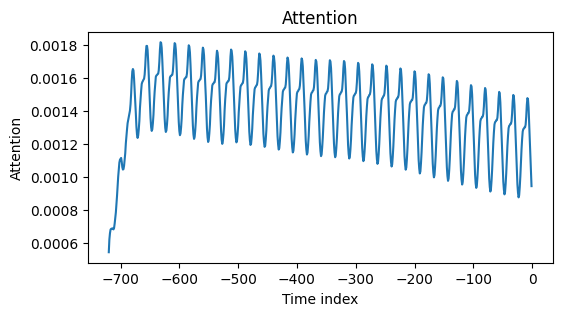

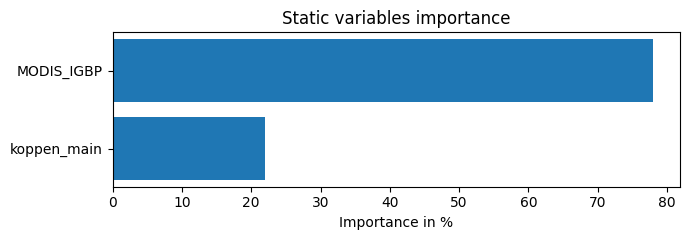

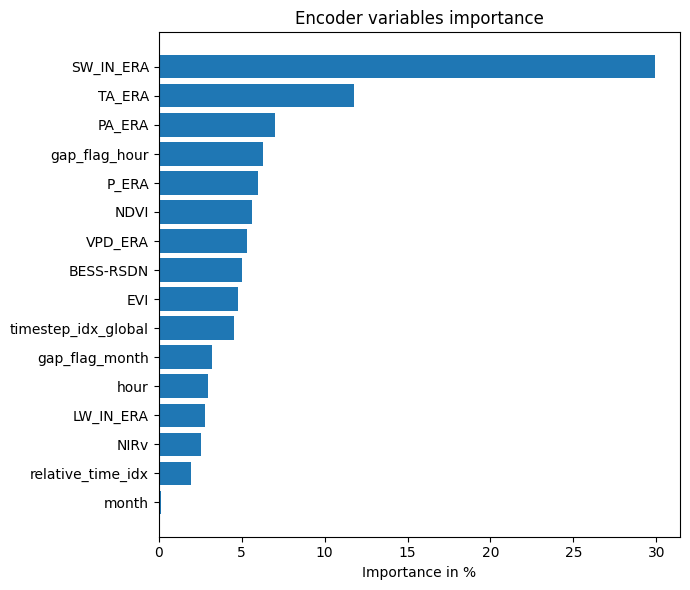

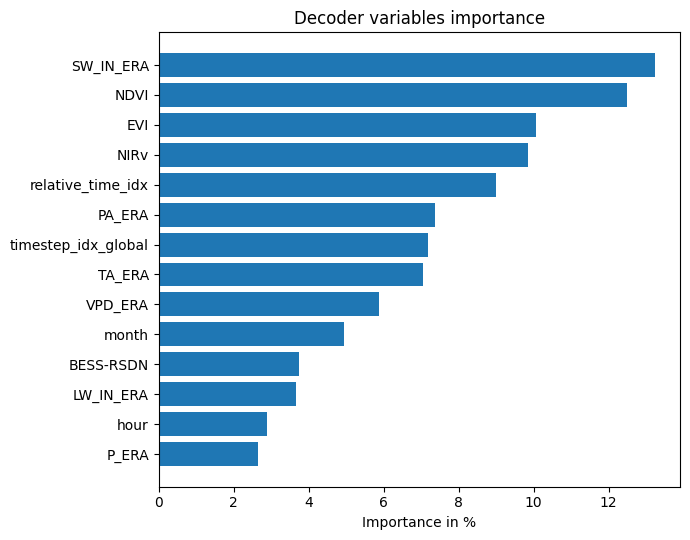

In [49]:
interpretation_sum = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation_sum)

### Plot examples

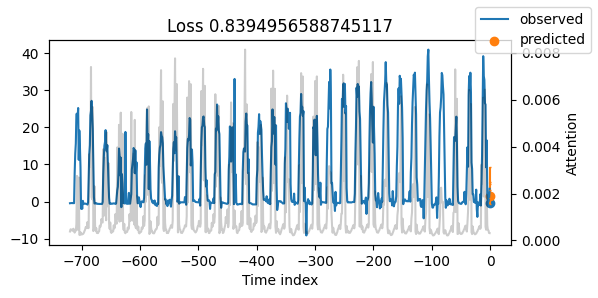

In [44]:
num_ex = 1
for idx in range(num_ex):
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

### Plot worst examples

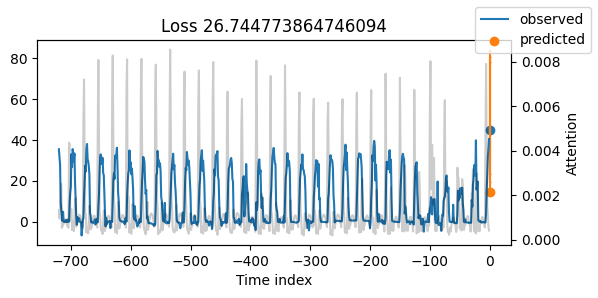

In [45]:
# Find worst RMSE scores in val set
num_bad_ex = 1
mean_losses = RMSE(reduction="none")(predictions, actuals.reshape(-1, 1)).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(num_bad_ex):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=True);

### Plot best examples

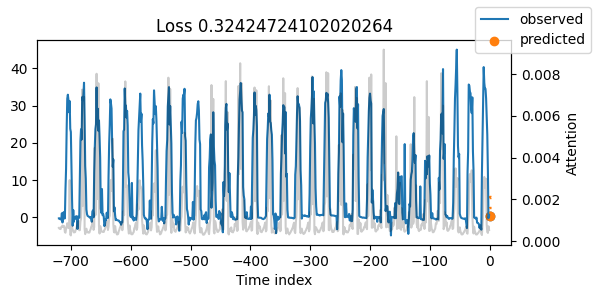

In [46]:
indices = mean_losses.argsort(descending=False)  # sort losses
for idx in range(num_bad_ex):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=True);

### Plot predictions by variable

In [ ]:
plt.rcParams['figure.figsize'] = [6, 3]

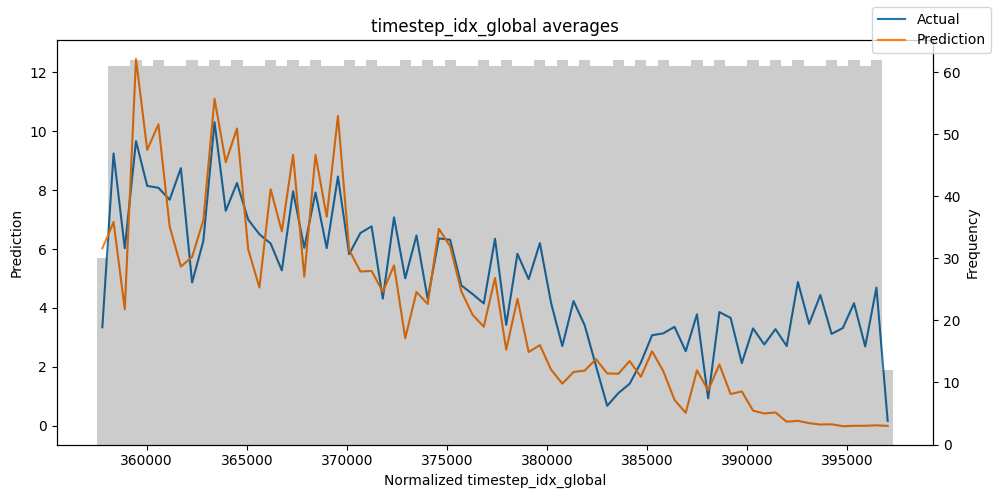

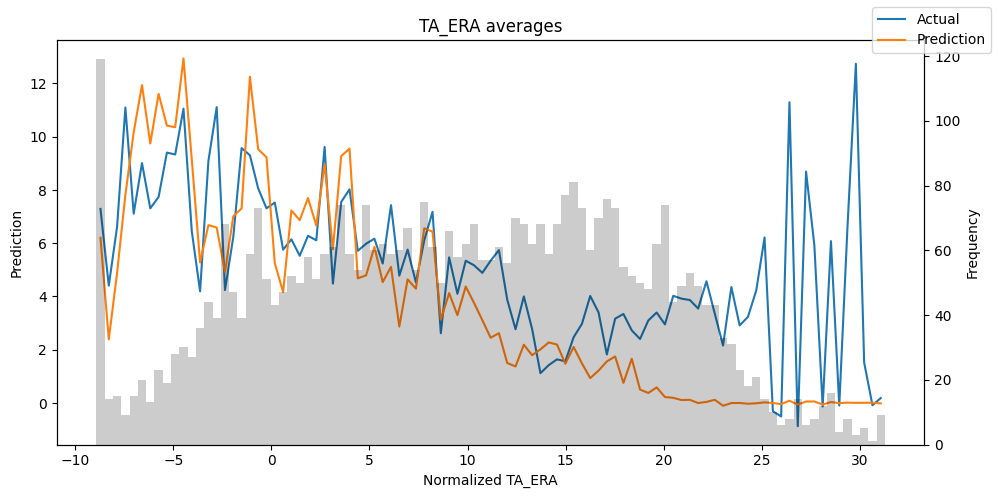

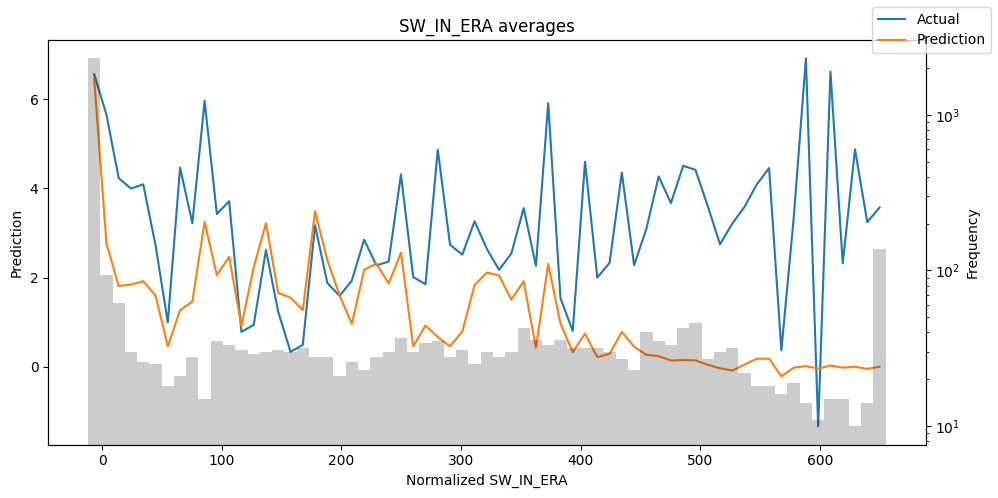

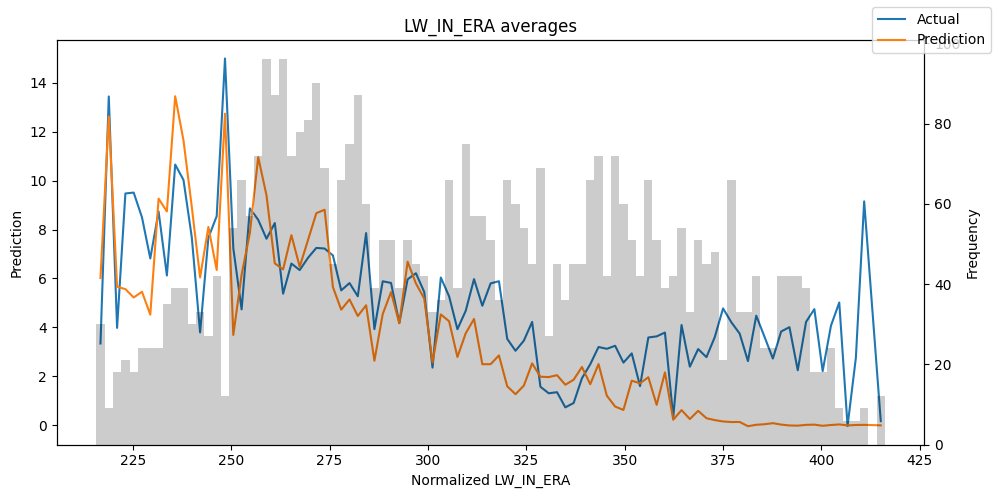

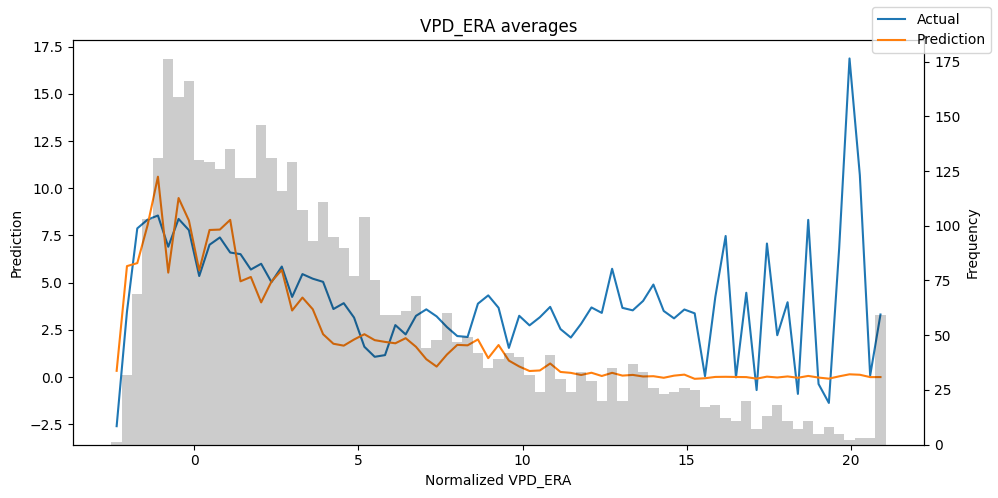

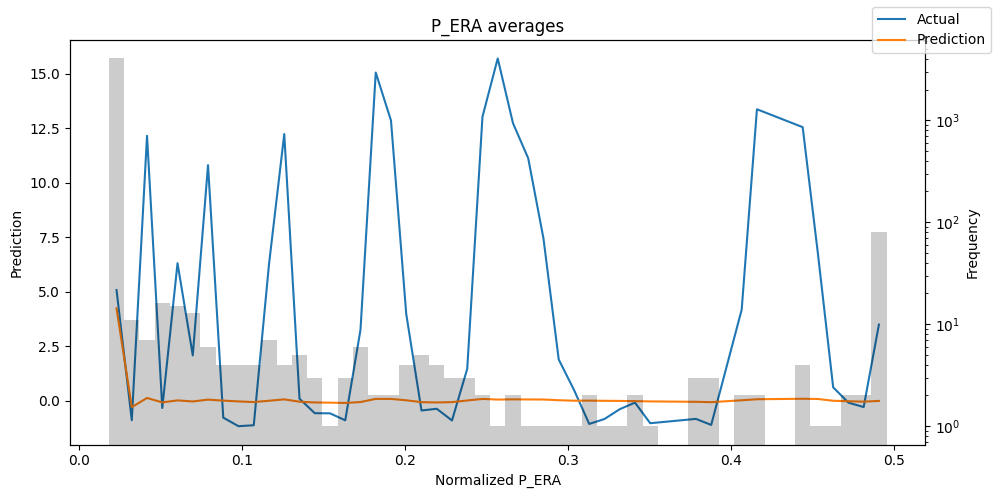

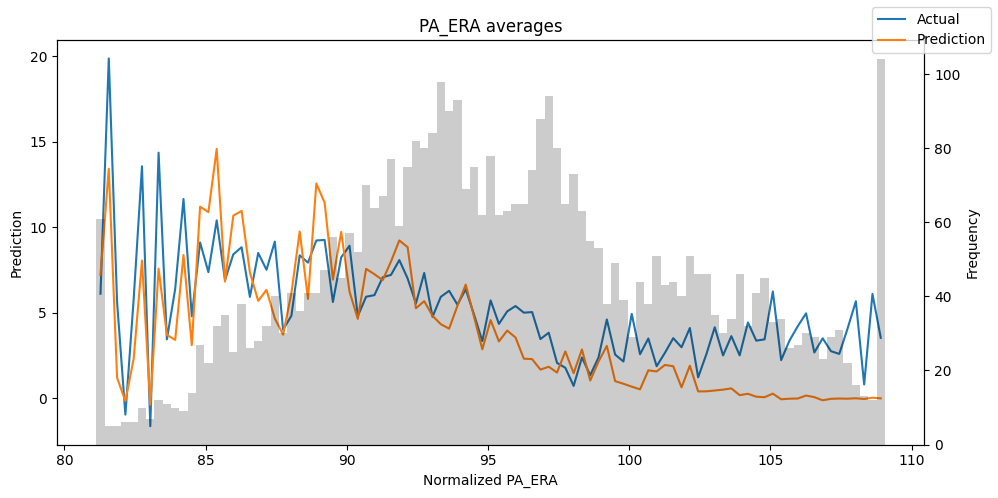

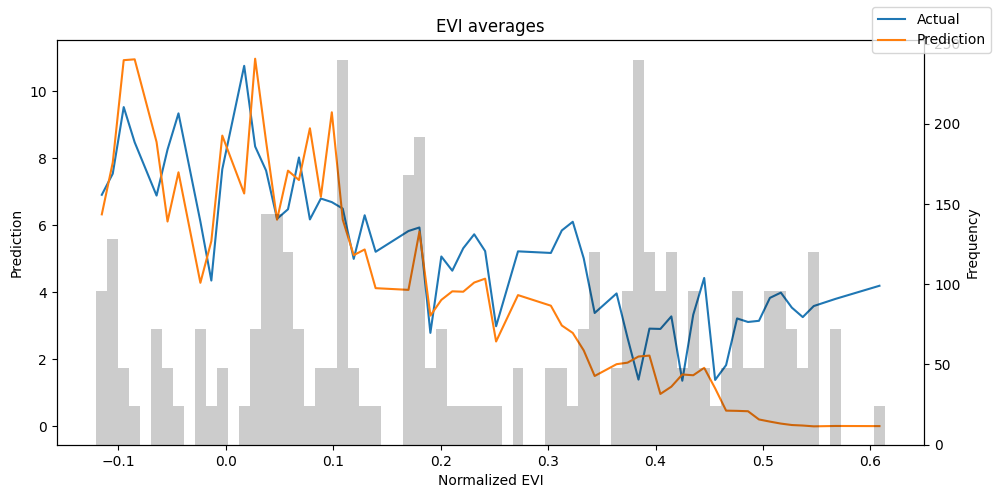

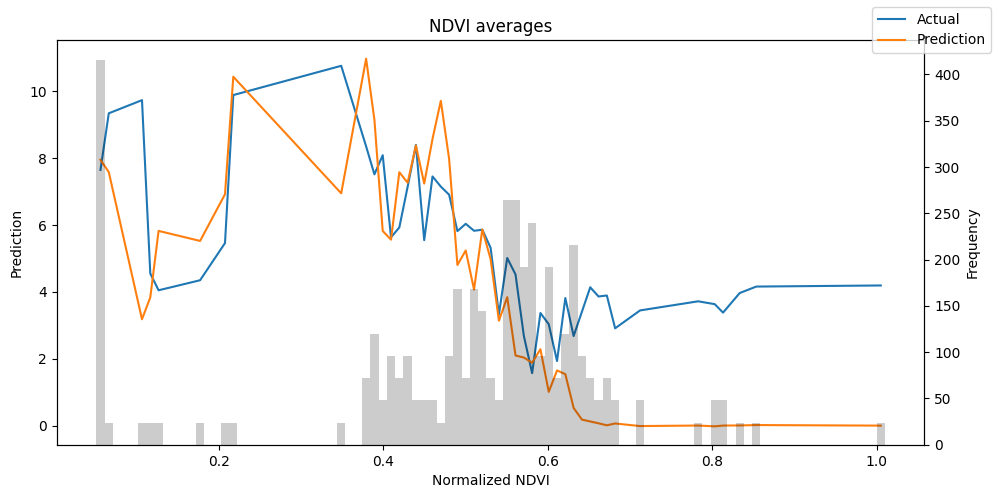

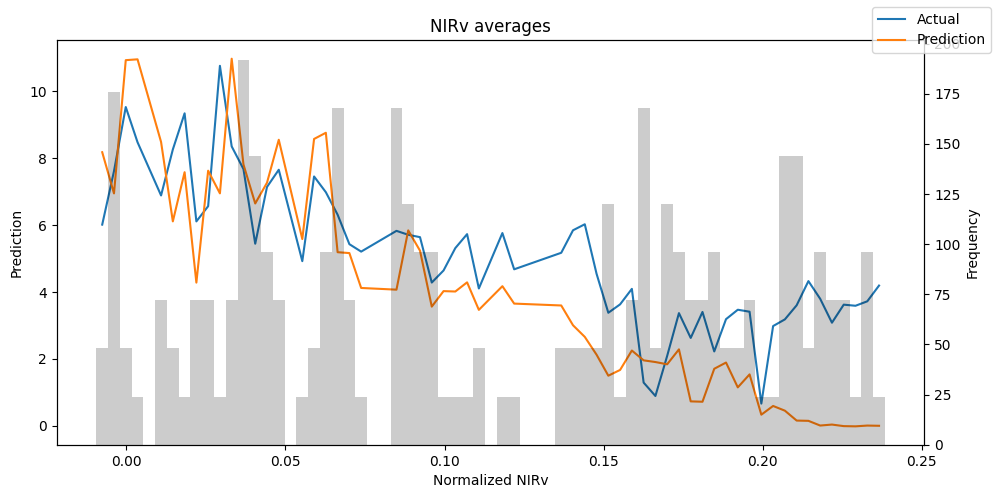

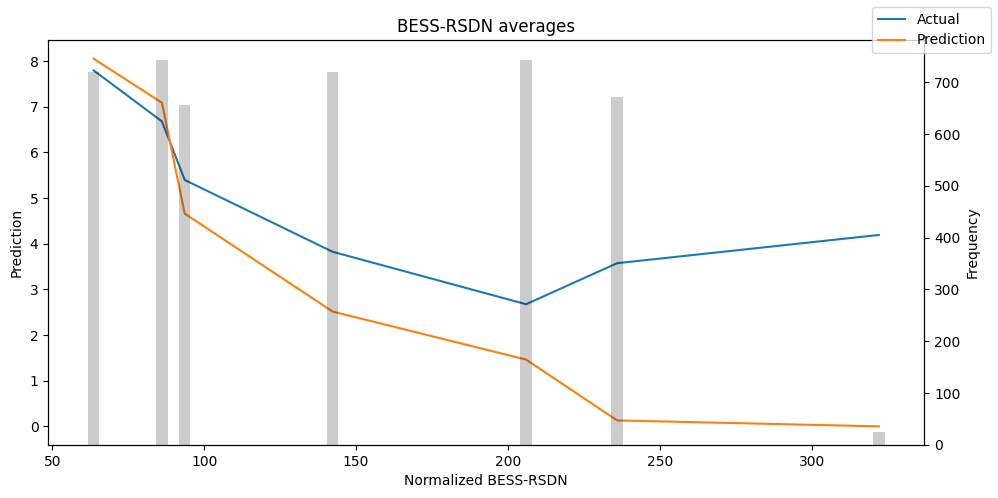

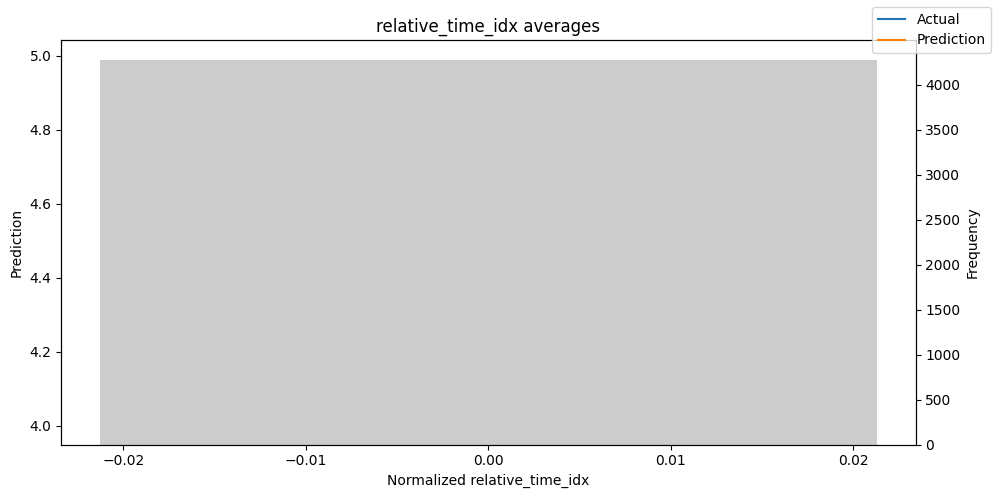

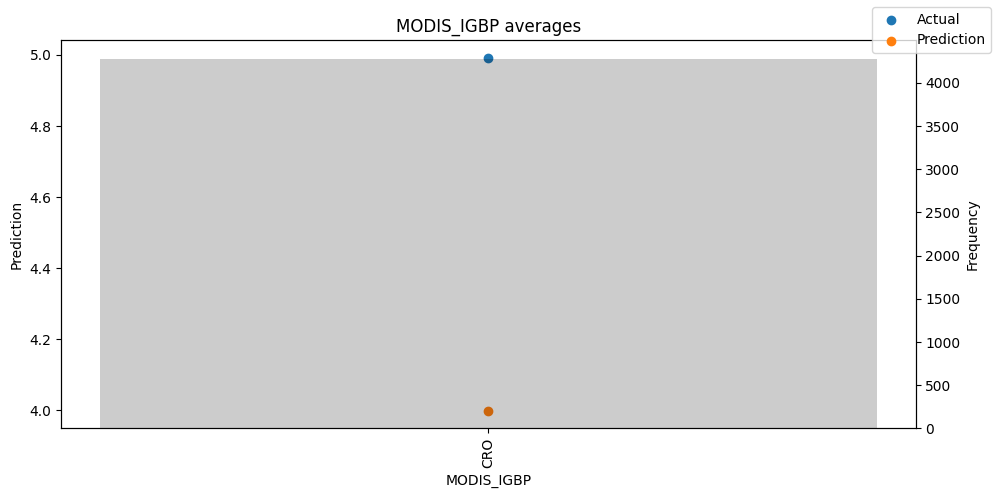

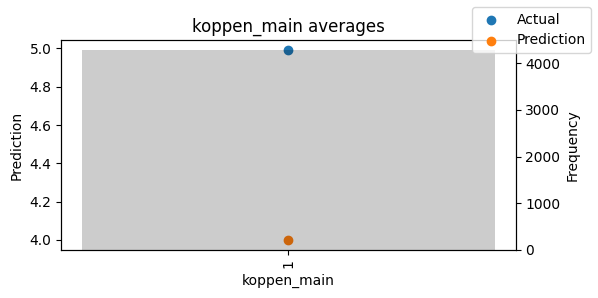

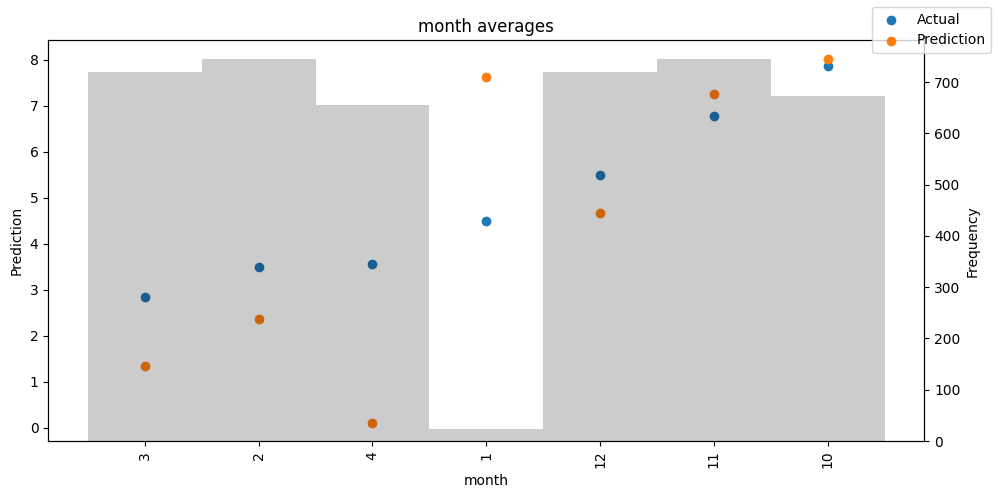

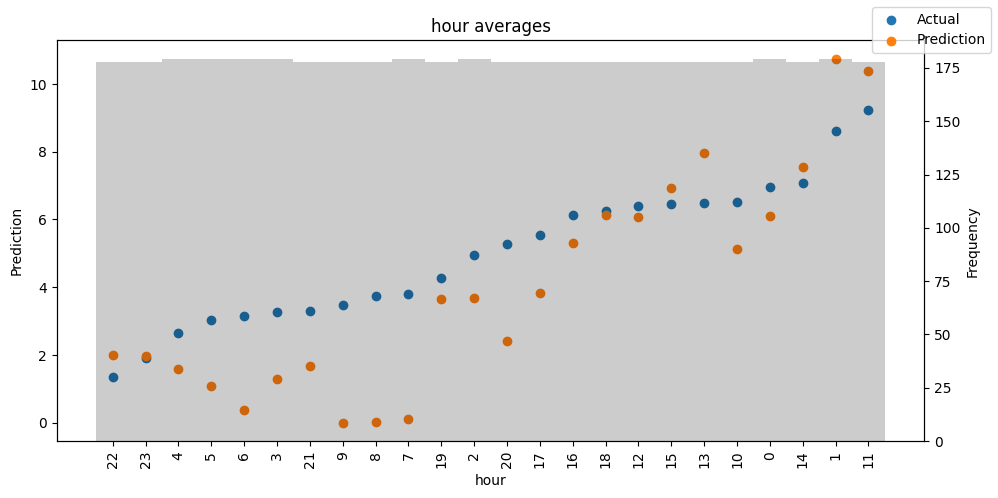

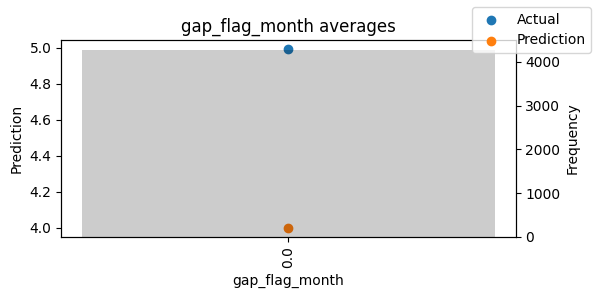

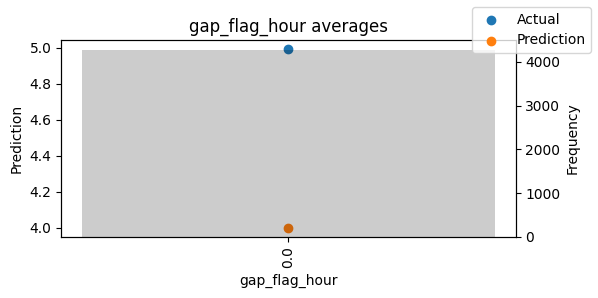

In [47]:
train_preds, x_train = best_tft.predict(train, return_x=True, show_progress_bar=False)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x_train, train_preds)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

### Plot predictions by IGBP


IGBP: CRO


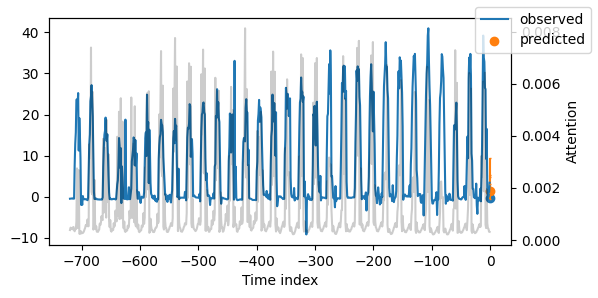

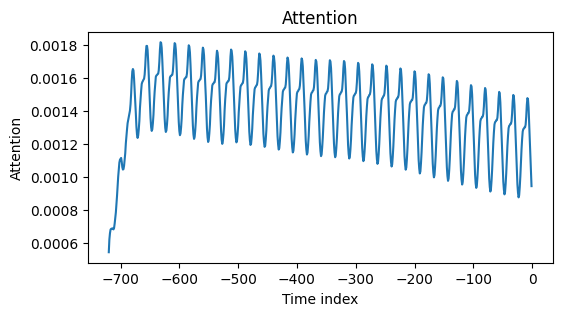

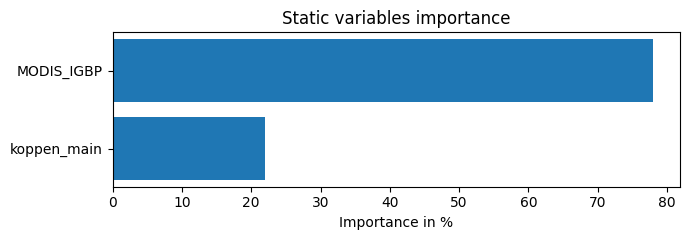

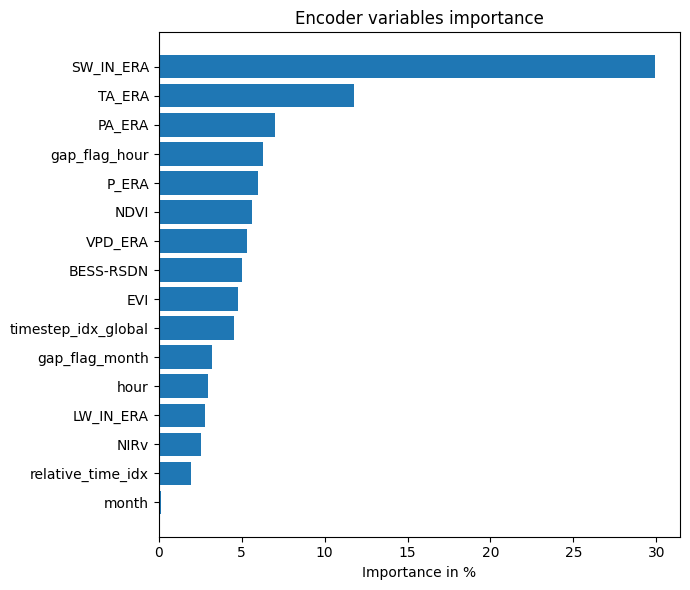

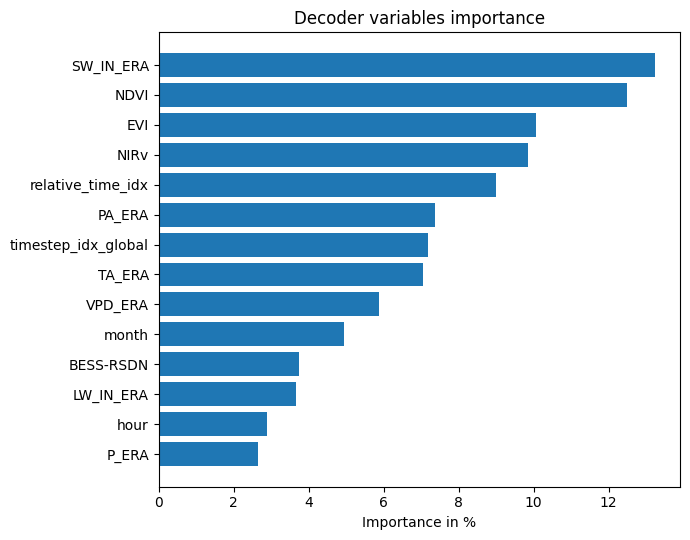

In [50]:
i = 0
igbp_groups = val_df.groupby('IGBP')

# Loop through each group and print the mean "value"
for group_name, group_df in igbp_groups:
    print(f"\nIGBP: {group_name}")
    _, val_igbp, _ = setup_tsdataset_nogpp_slim(train_df, group_df, None, ENCODER_LEN)
    raw_prediction_igbp, x_igbp = best_tft.predict(validation, mode="raw", return_x=True, show_progress_bar=False)
    
    # FILL IN
    best_tft.plot_prediction(x_igbp, raw_prediction_igbp, idx=0)
    
    # Interpret Outputs
    interpretation_sum = best_tft.interpret_output(raw_prediction_igbp, reduction="sum")
    best_tft.plot_interpretation(interpretation_sum)
    
    # Temp
    i +=1
    if i == 1:
        break

#### Plot predictions by Hour

In [66]:
validation.decoded_index

,site_id,time_idx_first,time_idx_last,time_idx_first_prediction
0,AU-DaP,350640,351360,351360
1,AU-DaP,350641,351361,351361
2,AU-DaP,350642,351362,351362
3,AU-DaP,350643,351363,351363
4,AU-DaP,350644,351364,351364
...,...,...,...,...
4275,AU-DaP,354915,355635,355635
4276,AU-DaP,354916,355636,355636
4277,AU-DaP,354917,355637,355637
4278,AU-DaP,354918,355638,355638


In [ ]:
# i = 0
# for hour_val in val_df['hour'].unique():
#     raw_prediction_igbp, x_igbp = best_tft.predict(
#         validation.filter(lambda x: (x.time_idx_first_prediction == 12)),
#         mode="raw",
#         return_x=True)
    
#     # FILL IN
#     best_tft.plot_prediction(x_igbp, raw_prediction_igbp, idx=0)
    
#     # Interpret Outputs
#     interpretation_sum = best_tft.interpret_output(raw_prediction_igbp, reduction="sum")
#     best_tft.plot_interpretation(interpretation_sum)
    
#     # Temp
#     if i == 0:
#         break

## Feature-Level Attention

In [ ]:
interpretation_none = best_tft.interpret_output(raw_predictions, reduction="none")

In [ ]:
# Determine which features align to "encoder_variables", validate against imoprtances above
enc_var_means = torch.mean(interpretation_none['encoder_variables'], dim=0).numpy()
time_varying_known_categoricals=["month", "hour"]
time_varying_unknown_categoricals=["gap_flag_hour"]
time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                        'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']
enc_var_names = time_varying_known_categoricals + time_varying_unknown_categoricals + time_varying_known_reals + ['relative_time_idx']
feature_imp_dict = dict(zip(enc_var_names, enc_var_means))
feature_imp_dict

In [ ]:
for key in raw_predictions.keys():
    print(f"key: {key}, shape: {raw_predictions[key].shape}")

### Investigate feature importances for 1 prediction

In [ ]:
# attention
fig, ax = plt.subplots()
attention = interpretation_none["attention"][pred_ind].detach().cpu()
attention = attention / attention.sum(-1).unsqueeze(-1)
ax.plot(attention)
ax.set_xlabel("Time index")
ax.set_ylabel("Attention")
ax.set_title(f"Attention for Pred Step {i}")
xticks_locations = range(0, len(attention), 10)
xticks_labels = range(-len(attention), 0, 10)
plt.xticks(xticks_locations, xticks_labels)
plt.show()

In [ ]:
# Get top timestep for pred 1
pred_ind = 0
ind = raw_predictions["encoder_attention"][pred_ind][0][0].argmax()
print(f"Top encoder attention index is for pred {pred_ind} is {ind-ENCODER_LEN}")

# Which feature is most important at this prediction step?
enc_vars_at_ind = raw_predictions["encoder_variables"][pred_ind][ind]
enc_ind = torch.argmax(enc_vars_at_ind)
feat_ind = enc_var_names[enc_ind]
print(f"Most important feature at index {ind-ENCODER_LEN} is {feat_ind}")

In [ ]:
# Whay do we care the most about? We probably care about analyzing the aggregate attention line chart. At each peak, what are the feature importances?

In [ ]:
# Pick one step, find the highest attention timestep, find 
pred_feat_importances = torch.mean(raw_predictions["encoder_variables"][pred_ind], dim=0)[0].numpy()

print(f"Prediction-Level Feature Importances at Pred Step {pred_ind}, across all encoder inds")
pred_feature_imp_dict = dict(zip(enc_var_names, pred_feat_importances))
sorted_dict = dict(sorted(pred_feature_imp_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict)

In [ ]:
val_df['IGBP'].unique()